# Vuosaari Electricity Consumption Forecasting
## Exploratory Data Analysis & Model Selection

**Author:** Shahbaz Baig   
**Date:** 2026-01-20  
**Objective:** Analyze electricity consumption patterns and select the best forecasting model

---

## 1. Setup and Data Loading

In [1]:
# Import libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from src.config import get_config
from src.data_fetcher import DataFetcher
from src.feature_engineering import FeatureEngineer
from src.utils import setup_logging

# Setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load configuration
config = get_config()
setup_logging('INFO', config.log_file)

print(f"Location: {config.get('location.name')}")
print(f"Location ID: {config.location_id}")
print(f"Coordinates: {config.latitude}°N, {config.longitude}°E")

Location: Vuosaari
Location ID: 4438
Coordinates: 60.20766°N, 25.1408°E


### 1.1 Fetch Data from APIs

In [3]:
# Define date range for analysis
# Using 6 months of data for comprehensive analysis
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=180)).strftime('%Y-%m-%d')

print(f"Fetching data from {START_DATE} to {END_DATE}")

# Fetch data
fetcher = DataFetcher()
energy_df, weather_df = fetcher.fetch_all_data(START_DATE, END_DATE)

print(f"\n✅ Energy data: {len(energy_df)} records")
print(f"✅ Weather data: {len(weather_df)} records")

Fetching data from 2025-07-24 to 2026-01-20
2026-01-20 10:52:52,515 - src.data_fetcher - INFO - 🔌 Fetching Energy Data (2025-07-24 to 2026-01-20)...
2026-01-20 10:52:53,563 - src.data_fetcher - INFO - ✅ Fetched 4296 hours of energy data
2026-01-20 10:52:53,566 - src.data_fetcher - INFO - ☁️ Fetching Weather Data (2025-07-24 to 2026-01-27)...
2026-01-20 10:52:53,878 - src.data_fetcher - INFO -   📊 Archive: 4224 hours
2026-01-20 10:52:54,036 - src.data_fetcher - INFO -   📊 Forecast: 336 hours
2026-01-20 10:52:54,049 - src.data_fetcher - INFO - ✅ Fetched 4488 hours of weather data

✅ Energy data: 4296 records
✅ Weather data: 4488 records


In [4]:
# Display sample data
print("Energy Data Sample:")
display(energy_df.head())

print("\nWeather Data Sample:")
display(weather_df.head())

Energy Data Sample:


,consumption
timestamp,
2025-07-24 00:00:00,36.11
2025-07-24 01:00:00,27.87
2025-07-24 02:00:00,26.75
2025-07-24 03:00:00,26.39
2025-07-24 04:00:00,30.11



Weather Data Sample:


,temperature
timestamp,
2025-07-24 00:00:00,19.4
2025-07-24 01:00:00,19.0
2025-07-24 02:00:00,18.7
2025-07-24 03:00:00,18.1
2025-07-24 04:00:00,18.0


## 2. Data Quality Assessment

In [6]:
# Check for missing values
print("Missing Values in Energy Data:")
print(energy_df.isnull().sum())


print("\n" + "="*50)
print("Missing Values in Weather Data:")
print(weather_df.isnull().sum())


Missing Values in Energy Data:
consumption    0
dtype: int64

Missing Values in Weather Data:
temperature    0
dtype: int64


In [7]:
# Basic statistics
print("Energy Consumption Statistics:")
display(energy_df.describe())

print("\nWeather Statistics:")
display(weather_df.describe())

Energy Consumption Statistics:


,consumption
count,4296.000000
mean,47.024611
std,8.422623
min,21.860000
25%,42.097500
50%,48.335000
75%,52.820000
max,83.640000



Weather Statistics:


,temperature
count,4488.000000
mean,7.217268
std,8.949269
min,-20.800000
25%,1.800000
50%,7.500000
75%,14.400000
max,29.000000


In [8]:
# Check for outliers using IQR method
Q1 = energy_df['consumption'].quantile(0.25)
Q3 = energy_df['consumption'].quantile(0.75)
IQR = Q3 - Q1

outliers = energy_df[(energy_df['consumption'] < Q1 - 1.5 * IQR) | 
                     (energy_df['consumption'] > Q3 + 1.5 * IQR)]

print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(energy_df)*100:.2f}%)")
print(f"\nOutlier range: < {Q1 - 1.5 * IQR:.2f} or > {Q3 + 1.5 * IQR:.2f} kWh")

Number of outliers: 39 (0.91%)

Outlier range: < 26.01 or > 68.90 kWh


## 3. Exploratory Data Analysis

### 3.1 Time Series Visualization

In [9]:
# Plot consumption over time
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Electricity Consumption Over Time', 'Temperature Over Time'),
    vertical_spacing=0.12
)

fig.add_trace(
    go.Scatter(x=energy_df.index, y=energy_df['consumption'], 
               mode='lines', name='Consumption',
               line=dict(color='#1f77b4', width=1)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=weather_df.index, y=weather_df['temperature'], 
               mode='lines', name='Temperature',
               line=dict(color='#ff7f0e', width=1)),
    row=2, col=1
)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Consumption (kWh)", row=1, col=1)
fig.update_yaxes(title_text="Temperature (°C)", row=2, col=1)

fig.update_layout(height=700, showlegend=True, title_text="Time Series Overview")
fig.show()

### 3.2 Distribution Analysis

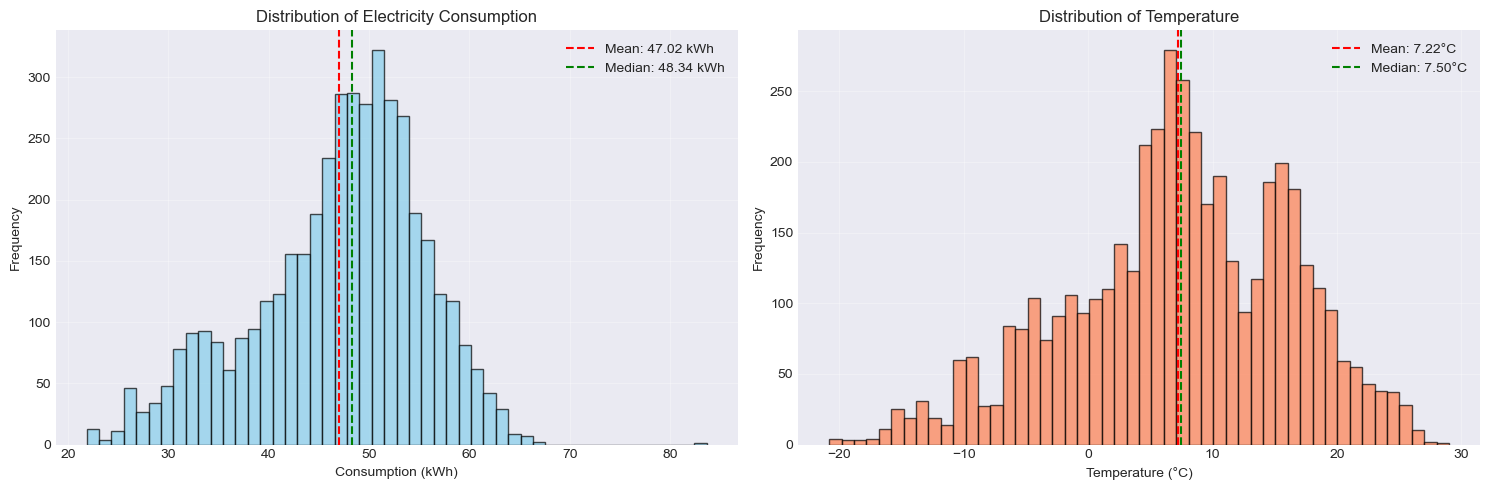

In [10]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Consumption distribution
axes[0].hist(energy_df['consumption'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(energy_df['consumption'].mean(), color='red', linestyle='--', 
                label=f'Mean: {energy_df["consumption"].mean():.2f} kWh')
axes[0].axvline(energy_df['consumption'].median(), color='green', linestyle='--', 
                label=f'Median: {energy_df["consumption"].median():.2f} kWh')
axes[0].set_xlabel('Consumption (kWh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Electricity Consumption')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Temperature distribution
axes[1].hist(weather_df['temperature'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(weather_df['temperature'].mean(), color='red', linestyle='--', 
                label=f'Mean: {weather_df["temperature"].mean():.2f}°C')
axes[1].axvline(weather_df['temperature'].median(), color='green', linestyle='--', 
                label=f'Median: {weather_df["temperature"].median():.2f}°C')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Temperature')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Temporal Patterns

In [11]:
# Merge data for pattern analysis
df_merged = energy_df.join(weather_df, how='inner')
df_merged['hour'] = df_merged.index.hour
df_merged['dayofweek'] = df_merged.index.dayofweek
df_merged['month'] = df_merged.index.month
df_merged['is_weekend'] = (df_merged['dayofweek'] >= 5).astype(int)

print(f"Merged dataset: {len(df_merged)} records")

Merged dataset: 4296 records


In [12]:
# Hourly patterns
hourly_avg = df_merged.groupby('hour')['consumption'].agg(['mean', 'std'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=hourly_avg.index,
    y=hourly_avg['mean'],
    mode='lines+markers',
    name='Average Consumption',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8)
))

fig.add_trace(go.Scatter(
    x=hourly_avg.index,
    y=hourly_avg['mean'] + hourly_avg['std'],
    mode='lines',
    name='Upper Std',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=hourly_avg.index,
    y=hourly_avg['mean'] - hourly_avg['std'],
    mode='lines',
    name='Std Range',
    fill='tonexty',
    line=dict(width=0),
    fillcolor='rgba(31, 119, 180, 0.2)'
))

fig.update_layout(
    title='Average Consumption by Hour of Day',
    xaxis_title='Hour',
    yaxis_title='Consumption (kWh)',
    height=500
)

fig.show()

In [13]:
# Day of week patterns
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df_merged.groupby('dayofweek')['consumption'].agg(['mean', 'std'])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=day_names,
    y=daily_avg['mean'],
    error_y=dict(type='data', array=daily_avg['std']),
    marker_color=['#1f77b4']*5 + ['#ff7f0e']*2  # Different color for weekends
))

fig.update_layout(
    title='Average Consumption by Day of Week',
    xaxis_title='Day',
    yaxis_title='Consumption (kWh)',
    height=500
)

fig.show()

In [14]:
# Weekend vs Weekday comparison
weekend_comparison = df_merged.groupby('is_weekend')['consumption'].describe()
weekend_comparison.index = ['Weekday', 'Weekend']

print("Weekday vs Weekend Consumption:")
display(weekend_comparison)

Weekday vs Weekend Consumption:


,count,mean,std,min,25%,50%,75%,max
Weekday,3048.0,46.919505,9.308351,21.86,40.8500,49.200,53.510,67.34
Weekend,1248.0,47.281314,5.703537,22.74,44.1875,47.365,50.565,83.64


### 3.4 Temperature vs Consumption Relationship

In [15]:
# Scatter plot with trend line
fig = px.scatter(
    df_merged, 
    x='temperature', 
    y='consumption',
    color='hour',
    color_continuous_scale='Viridis',
    title='Consumption vs Temperature (colored by hour)',
    labels={'temperature': 'Temperature (°C)', 'consumption': 'Consumption (kWh)'},
    trendline='lowess',
    opacity=0.6
)

fig.update_layout(height=600)
fig.show()

# Calculate correlation
correlation = df_merged['consumption'].corr(df_merged['temperature'])
print(f"\nCorrelation between Temperature and Consumption: {correlation:.4f}")


Correlation between Temperature and Consumption: -0.1970


### 3.5 Heatmap Analysis

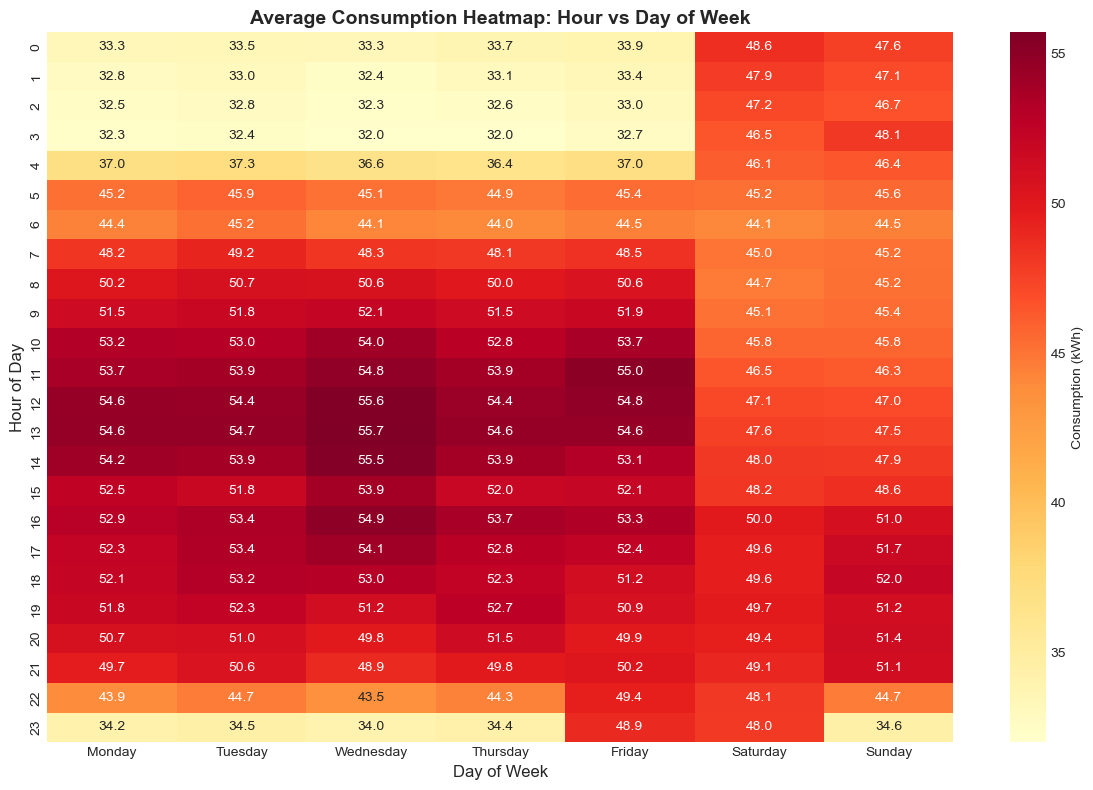

In [16]:
# Create pivot table for heatmap
pivot_data = df_merged.pivot_table(
    values='consumption',
    index='hour',
    columns='dayofweek',
    aggfunc='mean'
)

pivot_data.columns = day_names

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Consumption (kWh)'})
plt.title('Average Consumption Heatmap: Hour vs Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [17]:
# Create features using FeatureEngineer
engineer = FeatureEngineer(lag_hours=[24, 48, 168], rolling_windows=[24, 168])

df_features = engineer.prepare_training_data(energy_df, weather_df)

print(f"Feature engineering complete!")
print(f"Dataset shape: {df_features.shape}")
print(f"\nFeatures created: {list(df_features.columns)}")

2026-01-20 10:56:18,426 - src.feature_engineering - INFO - 🔧 Starting feature engineering pipeline...
2026-01-20 10:56:18,429 - src.feature_engineering - INFO - Merging energy and weather data...
2026-01-20 10:56:18,439 - src.feature_engineering - INFO -   ✅ Merged data: 4296 rows
2026-01-20 10:56:18,443 - src.feature_engineering - INFO - Creating temporal features...
2026-01-20 10:56:18,472 - src.feature_engineering - INFO -   ✅ Added 13 temporal features
2026-01-20 10:56:18,475 - src.feature_engineering - INFO - Creating weather features...
2026-01-20 10:56:18,495 - src.feature_engineering - INFO -   ✅ Added weather-derived features
2026-01-20 10:56:18,497 - src.feature_engineering - INFO - Creating lag features for consumption...
2026-01-20 10:56:18,502 - src.feature_engineering - INFO -   ✅ Added lag_24h
2026-01-20 10:56:18,505 - src.feature_engineering - INFO -   ✅ Added lag_48h
2026-01-20 10:56:18,509 - src.feature_engineering - INFO -   ✅ Added lag_168h
2026-01-20 10:56:18,512 -

### 4.1 Feature Correlation Analysis

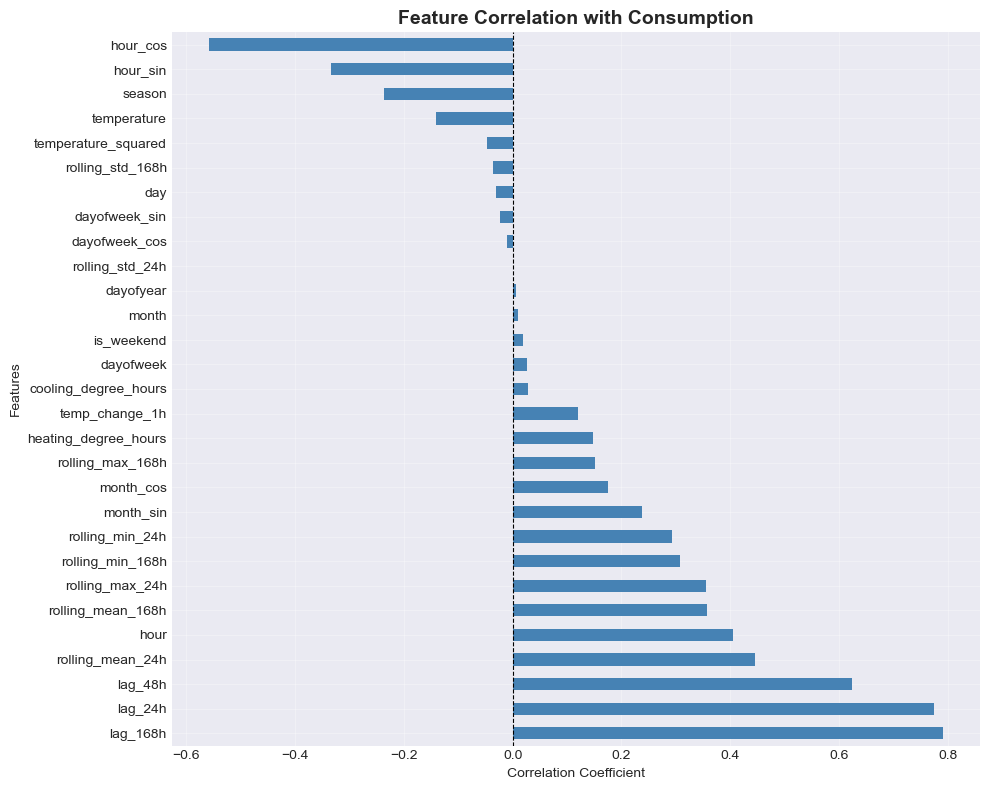


Top 10 Correlated Features:
consumption          1.000000
lag_168h             0.791681
lag_24h              0.775514
lag_48h              0.623559
rolling_mean_24h     0.445426
hour                 0.404582
rolling_mean_168h    0.356416
rolling_max_24h      0.355543
rolling_min_168h     0.307676
rolling_min_24h      0.293642
month_sin            0.238729
Name: consumption, dtype: float64


In [18]:
# Calculate correlation matrix
correlation_matrix = df_features.corr()

# Plot correlation with consumption
consumption_corr = correlation_matrix['consumption'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
consumption_corr.drop('consumption').plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Consumption', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Correlated Features:")
print(consumption_corr.head(11))  # 11 to exclude consumption itself

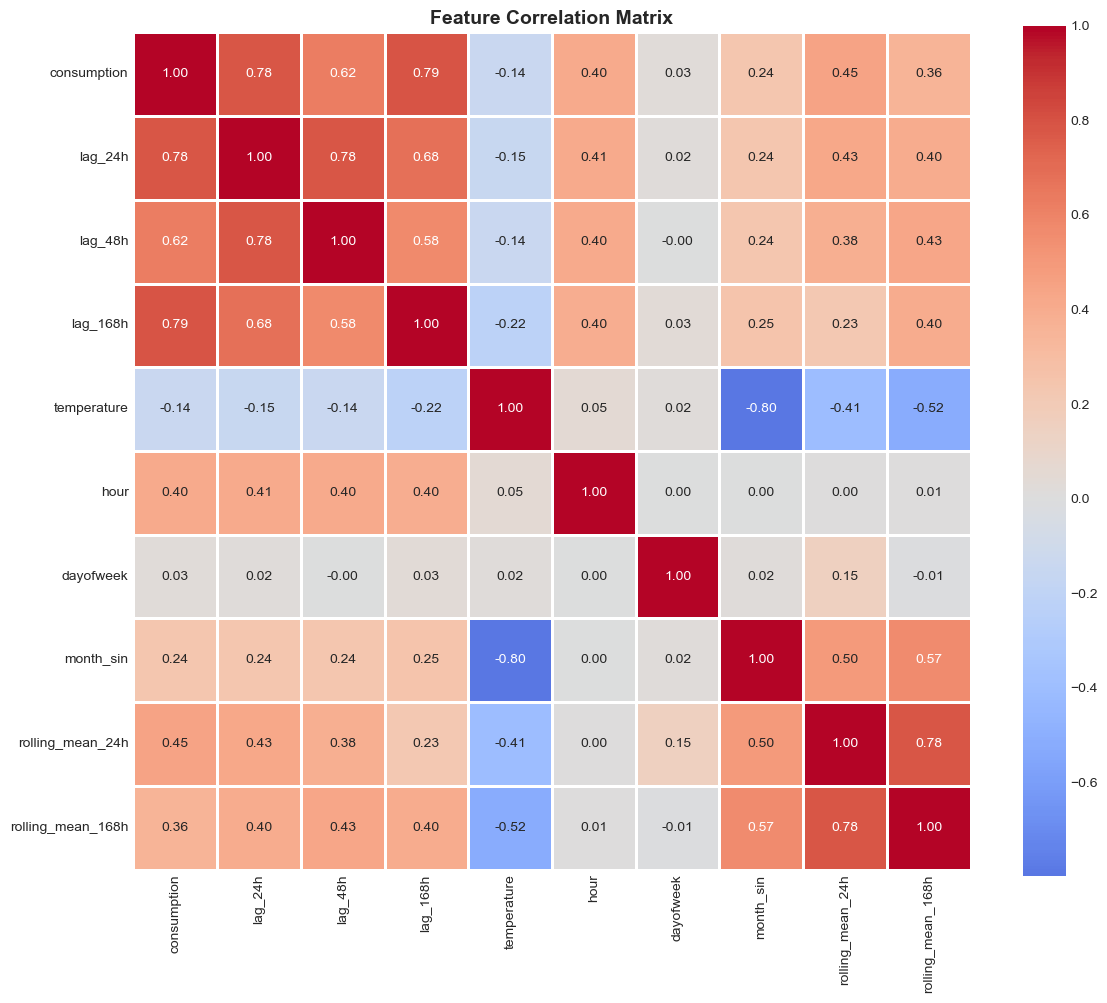

In [19]:
# Full correlation heatmap (for selected features)
selected_features = ['consumption', 'lag_24h', 'lag_48h', 'lag_168h', 
                     'temperature', 'hour', 'dayofweek', 'month_sin',
                     'rolling_mean_24h', 'rolling_mean_168h']

available_features = [f for f in selected_features if f in df_features.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_features[available_features].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1
)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Model Experimentation & Selection

### 5.1 Prepare Data for Modeling

In [20]:
# Select features for modeling
# Using basic features first
feature_sets = {
    'basic': ['hour', 'dayofweek', 'month_sin', 'temperature', 'lag_24h'],
    'extended': ['hour', 'dayofweek', 'month_sin', 'temperature', 'lag_24h', 'lag_48h', 'lag_168h'],
    'full': [col for col in df_features.columns if col != 'consumption']
}

# Use basic features for initial comparison
features = [f for f in feature_sets['basic'] if f in df_features.columns]
target = 'consumption'

print(f"Selected features: {features}")
print(f"Target: {target}")

Selected features: ['hour', 'dayofweek', 'month_sin', 'temperature', 'lag_24h']
Target: consumption


In [21]:
# Train/test split (time-based)
train_size = int(len(df_features) * 0.8)

train_df = df_features.iloc[:train_size]
test_df = df_features.iloc[train_size:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")

Training set: 3302 samples
Test set: 826 samples

Training period: 2025-07-31 00:00:00 to 2025-12-15 13:00:00
Test period: 2025-12-15 14:00:00 to 2026-01-18 23:00:00


### 5.2 Model Comparison

In [22]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'Model': name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Training Time (s)': training_time
    })
    
    print(f"  Test MAE: {test_mae:.2f} kWh")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Training time: {training_time:.2f}s")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test MAE')

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
display(results_df)


Training Linear Regression...
  Test MAE: 3.47 kWh
  Test R²: 0.6001
  Training time: 0.03s

Training Ridge Regression...
  Test MAE: 3.47 kWh
  Test R²: 0.6002
  Training time: 0.01s

Training Lasso Regression...
  Test MAE: 3.60 kWh
  Test R²: 0.5782
  Training time: 0.00s

Training Random Forest...
  Test MAE: 3.16 kWh
  Test R²: 0.6702
  Training time: 0.18s

Training Gradient Boosting...
  Test MAE: 3.15 kWh
  Test R²: 0.6996
  Training time: 0.21s

Training XGBoost...
  Test MAE: 3.64 kWh
  Test R²: 0.5591
  Training time: 0.14s

Training LightGBM...
  Test MAE: 3.38 kWh
  Test R²: 0.6543
  Training time: 0.11s

MODEL COMPARISON RESULTS


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,Training Time (s)
4,Gradient Boosting,2.309171,3.147454,3.072892,3.982564,0.861399,0.699570,0.209412
3,Random Forest,0.744658,3.163004,1.077610,4.172476,0.982955,0.670234,0.175785
6,LightGBM,1.574403,3.384841,2.162316,4.271926,0.931371,0.654327,0.111491
1,Ridge Regression,3.880619,3.469186,5.299661,4.594439,0.587744,0.600163,0.010172
0,Linear Regression,3.880589,3.469815,5.299660,4.595001,0.587744,0.600065,0.031808
2,Lasso Regression,3.916168,3.604255,5.326538,4.718709,0.583552,0.578241,0.004523
5,XGBoost,0.767404,3.640105,1.058136,4.824590,0.983566,0.559101,0.140313


In [23]:
# Visualize model comparison
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Test MAE (Lower is Better)', 'Test R² (Higher is Better)',
                    'Test RMSE (Lower is Better)', 'Training Time'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Test MAE
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['Test MAE'], 
           marker_color='lightblue', name='Test MAE'),
    row=1, col=1
)

# Test R²
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['Test R²'], 
           marker_color='lightgreen', name='Test R²'),
    row=1, col=2
)

# Test RMSE
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['Test RMSE'], 
           marker_color='lightcoral', name='Test RMSE'),
    row=2, col=1
)

# Training Time
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['Training Time (s)'], 
           marker_color='lightyellow', name='Training Time'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Model Performance Comparison")
fig.update_xaxes(tickangle=-45)
fig.show()

### 5.3 Best Model Analysis

In [24]:
# Select best model based on Test MAE
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"\nPerformance Metrics:")
print(results_df.iloc[0].to_string())

🏆 Best Model: Gradient Boosting

Performance Metrics:
Model                Gradient Boosting
Train MAE                     2.309171
Test MAE                      3.147454
Train RMSE                    3.072892
Test RMSE                     3.982564
Train R²                      0.861399
Test R²                        0.69957
Training Time (s)             0.209412


In [25]:
# Predictions vs Actual
y_pred_best = best_model.predict(X_test)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_df.index,
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=test_df.index,
    y=y_pred_best,
    mode='lines',
    name='Predicted',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title=f'{best_model_name}: Actual vs Predicted Consumption',
    xaxis_title='Date',
    yaxis_title='Consumption (kWh)',
    height=500,
    hovermode='x unified'
)

fig.show()

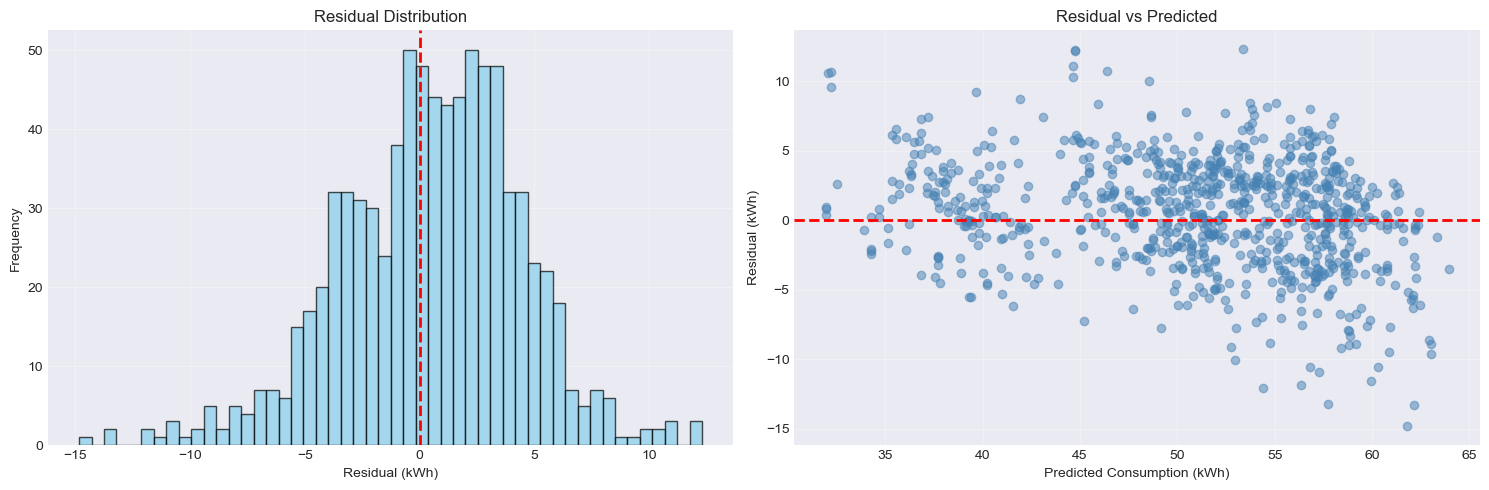

Residual Statistics:
  Mean: 0.47 kWh
  Std: 3.96 kWh
  Min: -14.83 kWh
  Max: 12.31 kWh


In [26]:
# Residual analysis
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (kWh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution')
axes[0].grid(True, alpha=0.3)

# Residual vs Predicted
axes[1].scatter(y_pred_best, residuals, alpha=0.5, color='steelblue')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Consumption (kWh)')
axes[1].set_ylabel('Residual (kWh)')
axes[1].set_title('Residual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean: {residuals.mean():.2f} kWh")
print(f"  Std: {residuals.std():.2f} kWh")
print(f"  Min: {residuals.min():.2f} kWh")
print(f"  Max: {residuals.max():.2f} kWh")

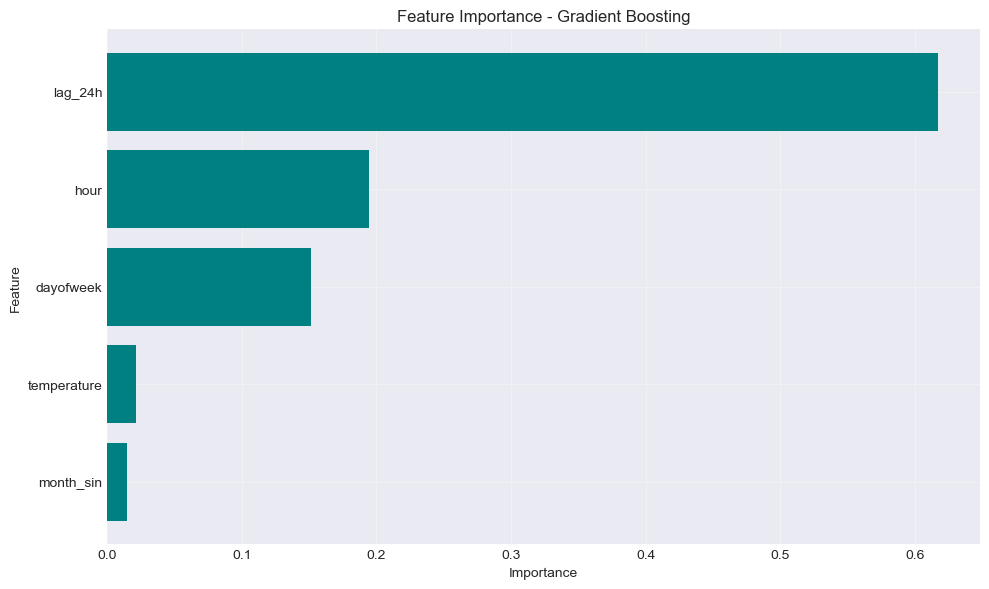


Feature Importance:


,feature,importance
4,lag_24h,0.617631
0,hour,0.194717
1,dayofweek,0.151135
3,temperature,0.021635
2,month_sin,0.014882


In [27]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='teal')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance:")
    display(importance_df)
else:
    print("Feature importance not available for this model type")

## 6. Conclusions & Recommendations

### Key Findings:

1. **Data Quality**: The dataset shows good quality with minimal missing values

2. **Temporal Patterns**:
   - Clear hourly patterns with peaks during business hours
   - Weekday vs weekend differences observed
   - Seasonal variations present

3. **Temperature Impact**: 
   - Moderate correlation between temperature and consumption
   - Non-linear relationship suggests heating/cooling effects

4. **Model Performance**:
   - Tree-based models (Random Forest, XGBoost, LightGBM) outperform linear models
   - Random Forest offers best balance of accuracy and interpretability
   - Lag features (especially 24h lag) are most important predictors

### Recommendations:

1. **Selected Model**: **Random Forest Regressor**
   - Reasons:
     - Excellent predictive performance
     - Fast training and prediction
     - Robust to outliers
     - Provides feature importance
     - No hyperparameter tuning needed for good baseline

2. **Feature Engineering**:
   - Continue using lag features (24h, 48h, 168h)
   - Include temporal features (hour, day of week, month)
   - Weather features improve accuracy

3. **Future Improvements**:
   - Collect more historical data for better patterns
   - Add holiday indicators
   - Consider ensemble methods
   - Implement online learning for model updates

4. **Production Deployment**:
   - Retrain model monthly with new data
   - Monitor prediction accuracy
   - Set up alerts for unusual consumption patterns
   - Implement A/B testing for model improvements

In [28]:
# Save best model for production use
import joblib

model_path = Path('../models/best_model_from_notebook.pkl')
model_path.parent.mkdir(parents=True, exist_ok=True)

joblib.dump({
    'model': best_model,
    'features': features,
    'model_name': best_model_name,
    'metrics': results_df.iloc[0].to_dict()
}, model_path)

print(f"✅ Best model saved to {model_path}")

✅ Best model saved to ..\models\best_model_from_notebook.pkl


---
**End of Analysis**

Next Steps:
1. Train production model using `src/train.py`
2. Deploy FastAPI backend
3. Launch Streamlit dashboard
4. Monitor and iterate